# Solve the NN driven model in a scene

## Import libraries

In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import tensorflow as tf
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
sys.path.append("myfun/")
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_model_nn import *
from ipynb.fs.defs.myfun_plot import *
from ipynb.fs.defs.myfun_model_usefulfuns import *

2023-12-08 18:29:33.832905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post') # we have 10 pandas dataframe, one for each couple(camera,sequence)

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[0] # sequence
scn = df.T[0]  # scene

In [4]:
scn

Tarr              [14.240000000000002, 14.440000000000001, 14.64]
Xarr            [[47.39131045666992, 53.82017733698899, 60.334...
cons_dis        [[3.9987357284027283, 1.7240925784948118, 0.06...
N. vehicles                                                     3
cam                                                             1
day                                                             1
seq                                                             1
N. file                                                         1
Xarr_std        [[-0.47489203804198415, -0.11463101384939701, ...
XarrMean                                                55.865771
XarrStd                                                 17.845025
cons_dis_std    [[0.22408126592261313, 0.09661474870989278, 0....
Name: 0, dtype: object

In [5]:
# Useful params
N = scn['N. vehicles']
tstamps = scn['Tarr']

## Just to know the input of the NN

In [6]:
# Just to see what will be the X and y for our NN
X_arr, y_arr = create_data_ann_scene(scn)

print(f"We solve the NN driven ODE sys in each time interval of len=0.2s inside [{tstamps[0]},{tstamps[-1]}].\n\n\
In the first time interval [{tstamps[0]},{tstamps[1]}] we evaluate our NN using as:\n\
\t * X: {X_arr[:,1]} (consecutive distances btw the {N} vehicles)\n\
\t * y: {y_arr[:,1]} (approximated velocities)")

We solve the NN driven ODE sys in each time interval of len=0.2s inside [14.240000000000002,14.64].

In the first time interval [14.240000000000002,14.440000000000001] we evaluate our NN using as:
	 * X: [ 1.72409258 21.71186802] (consecutive distances btw the 3 vehicles)
	 * y: [32.5721373  24.27162308] (approximated velocities)


## Create the model NN

In [7]:
DOE =[[1,2,1]] #Design of experiment

# # Create the model
model = create_model(DOE[0])

In [8]:
get_stats(model, flag_summary=True)


-------------------- Model Summary --------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 2         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Layer:  Hidden-Layer-1
  --Kernels (Weights): 
[[ 0.3767624  -0.27783966]]
  --Biases: 
[-0.01338863 -0.69605947]

Layer:  Output-Layer
  --Kernels (Weights): 
[[-0.32891917]
 [-0.3808496 ]]
  -- No biases




## Evaluate the NN in each time interval

In [9]:
v0 = 30
LEARNING_RATE_NN = 0.001
LEARNING_RATE_v0=0.5
NUM_ITER = 500
info_flag = True

----------------------------------------------------------------------------------------------------
We have 2 time intervals inside [14.24,14.64]
            Interval n.0: [14.24, 14.44]
                * y_true: [32.1443344  20.77111865]
                * v_ann: [27.319944381713867, 32.54178237915039, 27.63627828527224]

            Interval n.1: [14.44, 14.64]
                * y_true: [32.5721373  24.27162308]
                * v_ann: [25.037063598632812, 22.69179344177246, 27.63627828527224]

        Some info:
        * MSE = 1.8684404018337786
        * Learning rate NN = 0.0007289999630302191
        * diff (update rule for LR NN) = 0.073862873748884
        * It = 500


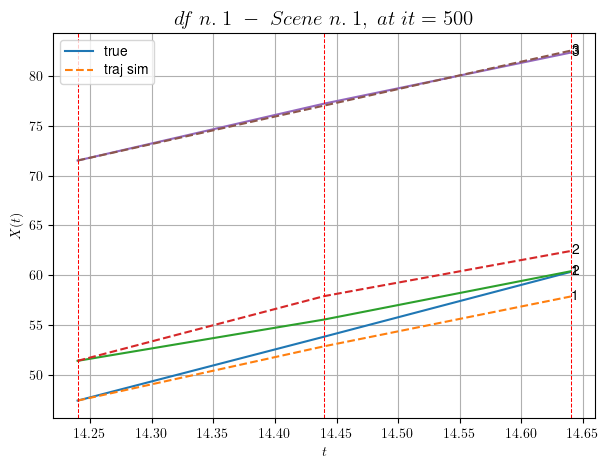

----------------------------------------------------------------------------------------------------


In [10]:
t_cus, x_cus, _, _, _ = solve_nn_scn(model, scn, v0, LEARNING_RATE_NN, LEARNING_RATE_v0, NUM_ITER, info_flag)

### Plot

In [11]:
# Params for the plot
trajs = [scn['Xarr'],  np.array(x_cus)]
labels_plot = ["true", "nn sim custom"]
title = f"Trajs simulated by NN driven LWR model"

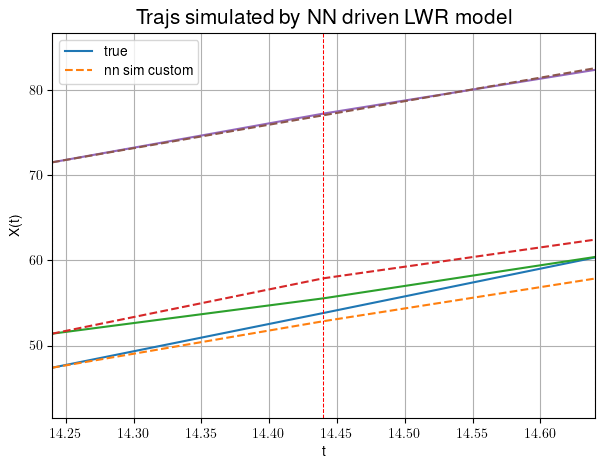

In [12]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(t_cus, x_cus[veh], '--')

for ts in tstamps:
    ax.axvline(x = ts, color = 'red', linestyle = '--', linewidth=0.75)
    
# Annotate the name of each variable at the last value
plot_annotation(ax, scn, trajs, scale=1.004)

ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# Limits for the plot
plot_limits(ax, scn, trajs, xbal=0, ybal=0.05)
plt.legend(labels_plot)
plt.grid()
plt.show()

## Match the computed solution to the same timestamps of the scene

In [13]:
deltat = 0.05

# To recover the same timestep in the data
factor = int(0.2/deltat)

if len(set(tstamps - np.array(t_cus)[::factor])) == 1:
    print(f"timestamps coincide!")
    print("* tstamps: \t\t\t", tstamps,\
          "\n* np.array(t_ann_list): \t",np.array(t_cus)[::factor])
else:
    print(f"There is a mismatch in the timestamps: tstamps != tspan[::factor]")

timestamps coincide!
* tstamps: 			 [14.24 14.44 14.64] 
* np.array(t_ann_list): 	 [14.24 14.44 14.64]


In [14]:
# ## To match solution and timestamps
# t_cus_matched = np.array(t_cus)[::factor]
# x_cus_matched = np.array([traj[::factor] for traj in x_cus])

# # Other way to plot the trajs
# plot_scn(scn, x_cus_matched)